In [1]:
import cv2 #opencv读取的格式是BGR
import numpy as np
import matplotlib.pyplot as plt#Matplotlib是RGB
%matplotlib inline 

In [2]:
def cv_show(img,name):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

### 直方图

直方图是对数据集合统计，并将统计结果分布于一系列定义的bins中。这里的数据不仅仅是灰度值，统计数据可能是任何能够有效描述图像的特征，例如颜色、梯度/边缘、形状、纹理、局部特征点、视觉词汇等。在计算机视觉领域通常用来指反映图片的亮度，色彩，强度在整个图片里面的分布情况。

在计算机视觉领域，常常要处理各种各样的图片，通过观察图片的直方图，可以使我们在加工图片时更加合理的调整一些函数的参数，比如边缘检测，高斯模糊，切割，透视，二值化等等。

利用直方图可以对图片的均衡化（对比度）进行调整，包括局部调整

#### cv2.calcHist(images,channels,mask,histSize,ranges)

- images: 原图像图像格式为 uint8 或 ﬂoat32。当传入函数时应 用中括号 [] 括来例如[img]
- channels: 同样用中括号括来它会告函数我们统幅图 像的直方图。如果入图像是灰度图它的值就是 [0]如果是彩色图像 的传入的参数可以是 [0][1][2] 它们分别对应着 BGR。 
- mask: 掩模图像。统整幅图像的直方图就把它为 None。但是如 果你想统图像某一分的直方图的你就制作一个掩模图像并 使用它。
- histSize:BIN 的数目。也应用中括号括来
- ranges: 像素值范围常为 [0256] 

In [3]:
img = cv2.imread('img/cat.jpg',0) #0表示灰度图
hist = cv2.calcHist([img],[0],None,[256],[0,256])

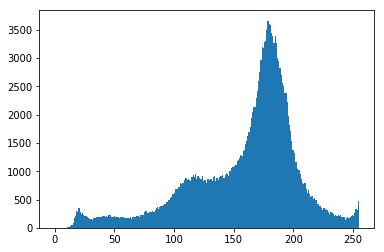

In [4]:
plt.hist(img.ravel(),256); 
plt.show()

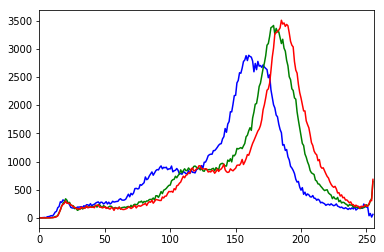

In [5]:
img = cv2.imread('img/cat.jpg') 
color = ('b','g','r')
for i,col in enumerate(color): 
    histr = cv2.calcHist([img],[i],None,[256],[0,256]) 
    plt.plot(histr,color = col) 
    plt.xlim([0,256]) 


### mask操作
要统计图像某个局部区域的直方图只需要构建一副掩模图像。将要统计的部分设置成白色，其余部分为黑色，就构成了一副掩模图像。然后把这个掩模图像传给函数就可以了。

In [6]:
# 创建mast
mask = np.zeros(img.shape[:2], np.uint8)
print (mask.shape)
mask[100:300, 100:400] = 255
cv_show(mask,'mask')

(414, 500)


In [7]:
img = cv2.imread('img/cat.jpg', 0)
cv_show(img,'img')

In [8]:
masked_img = cv2.bitwise_and(img, img, mask=mask)#与操作
cv_show(masked_img,'masked_img')

In [10]:
hist_full = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_mask = cv2.calcHist([img], [0], mask, [256], [0, 256])

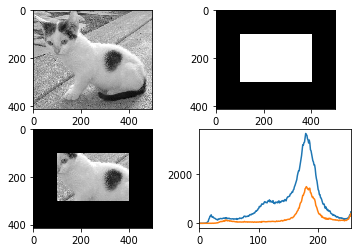

In [11]:
plt.subplot(221), plt.imshow(img, 'gray')
plt.subplot(222), plt.imshow(mask, 'gray')
plt.subplot(223), plt.imshow(masked_img, 'gray')
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0, 256])
plt.show()

### 直方图均衡化
直方图均衡化就是将原始的直方图拉伸，使之均匀分布在全部灰度范围内，从而增强图像的对比度。

直方图均衡化的中心思想是把原始图像的的灰度直方图从比较集中的某个区域变成在全部灰度范围内的均匀分布。旨在使得图像整体效果均匀，黑与白之间的各个像素级之间的点更均匀一点。

![title](img/hist_2.png)
![title](img/hist_3.png)
![title](img/hist_4.png)

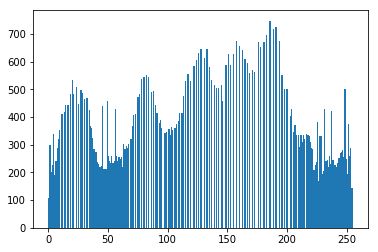

In [24]:
equ = cv2.equalizeHist(img) 
plt.hist(equ.ravel(),256)
plt.show()

#### 自适应直方图均衡化
自适应直方图均衡化的实现方法首先是将图像划分成不重叠的区域块，让后对每个块分别进行直方图均衡化处理。如果在图像有噪声的情况下这样处理，在每个被分割的小区域块中的噪声就会被放大。

为了避免噪声对图像均衡化的影响，使用限制对比度的自适应直方图均衡化来处理图像的直方图均衡化。限制对比度的直方图均衡化的处理方式是先为直方图设置一个阈值，该阈值为限制对比度值，超过该阈值的值会被裁剪，然后裁剪的部分会均匀的分布到其他值上，这样就重构了直方图，接下来就可以用重构后的直方图来进行接下来的均衡化操作了。

cv2.createCLAHE
clipLimit：越大的话，对比度越低
tileGridSize:划分每个区域块的大小

In [25]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) 

In [26]:
res_clahe = clahe.apply(img)
res = np.hstack((img,equ,res_clahe))
cv_show(res,'res')

### 傅里叶变换
傅里叶变换可以将一副图片分解为正弦和余弦两个分量，换言之，它可以将一幅图像从空间域（spatial domain）转换为频域（frequency domain）。这种变换的思想是任何函数可以很精确的接近无穷个sin()函数和cos()函数的和。

空间域
一般情况下，空间域的图像是f(x, y) = 灰度级（0-255），形象一点就是一个二维矩阵，每一个坐标对应一个颜色值。

频率域
频率：对于图像来说就是指图像颜色值的梯度，即灰度级的变化速度
幅度：可以简单的理解为是频率的权，即该频率所占的比例

### 傅里叶变换的作用

得到图像中几何结构信息

- 高频：变化剧烈的灰度分量，例如边界

- 低频：变化缓慢的灰度分量，例如一片大海

还有一个作用，傅里叶变化可以将空间域转换为频率域，可以转换后进行卷积计算，这样计算速度会更快然后再转换为空间域

### 滤波

- 低通滤波器：只保留低频，会使得图像模糊

- 高通滤波器：只保留高频，会使得图像细节增强



- opencv中主要就是cv2.dft()和cv2.idft()，输入图像需要先转换成np.float32 格式。
- 得到的结果中频率为0的部分会在左上角，通常要转换到中心位置，可以通过shift变换来实现。
- cv2.dft()返回的结果是双通道的（实部，虚部），通常还需要转换成图像格式才能展示（0,255）

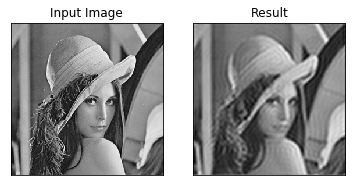

In [27]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('img/lena.jpg',0)

img_float32 = np.float32(img)

dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

rows, cols = img.shape
crow, ccol = int(rows/2) , int(cols/2)     # 中心位置

# 低通滤波
mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# IDFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Result'), plt.xticks([]), plt.yticks([])

plt.show() 

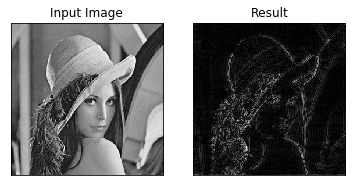

In [28]:
img = cv2.imread('img/lena.jpg',0)

img_float32 = np.float32(img)

dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

rows, cols = img.shape
crow, ccol = int(rows/2) , int(cols/2)     # 中心位置

# 高通滤波
mask = np.ones((rows, cols, 2), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 0

# IDFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Result'), plt.xticks([]), plt.yticks([])

plt.show() 